# Simulating 2D Epileptor model

In [1]:
import os
import sys
import time
import errno
import time


import numpy as np
import scipy as scp
import scipy as scp
import matplotlib.pyplot as plt

import re
import pandas as pd
import seaborn as sns


In [2]:
from scipy.integrate import odeint

In [3]:
from scipy import stats as spstats

In [4]:
from scipy.optimize import fsolve
from scipy.optimize import root

In [5]:
import numpy as np
import torch

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt


In [6]:
import sbi.utils as utils
from sbi.inference.base import infer

from sbi.inference import SNPE, prepare_for_sbi
from sbi.utils.get_nn_models import posterior_nn

In [7]:
%pylab inline
#%matplotlib notebook

Populating the interactive namespace from numpy and matplotlib


In [8]:
plt.style.use('seaborn-talk');

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'

In [9]:
cwd = os.getcwd()
cwd

'/data/SBI'

In [10]:
T = 120.0
dt=0.1
ts = np.arange(0, T + dt, dt)
sigma=1e-1

In [11]:
nt=ts.shape[0]
nt

1201

In [12]:
tau0=100.
I1=3.1
eta_true=-1.5

In [13]:
x, z= np.zeros(nt), np.zeros(nt)

In [14]:
x_init, z_init=-2.5, 3.5
x[0],z[0]=x_init, z_init

In [15]:
for i in range(1, nt):
    dx =1.0 - x[i-1]**3 - 2.0*x[i-1]**2 - z[i-1] + I1   
    dz =(1.0/tau0)*(4*(x[i-1]-eta_true) - z[i-1])
    x[i]=(x[i-1] + dt * dx )
    z[i]=(z[i-1] + dt * dz)    

In [16]:
ts.shape, x.shape

((1201,), (1201,))

/home/meysam/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


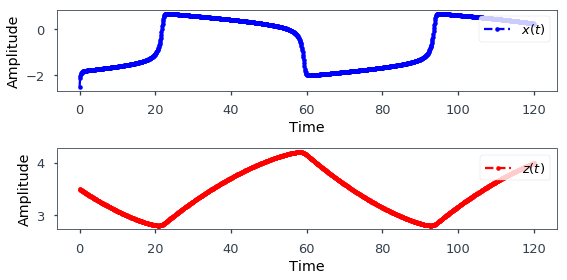

In [17]:
plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.plot(ts,x , '--b.', label='$x(t)$')
plt.xlabel('Time'); plt.ylabel('Amplitude'); 
plt.legend(loc='upper right')
plt.tight_layout();
plt.subplot(212)
plt.plot(ts, z, '--r.', label='$z(t)$')
plt.xlabel('Time'); ylabel('Amplitude'); 
plt.legend(loc='upper right')
plt.tight_layout();
plt.show()

In [18]:
def dy_dt(y, ts, eta):
    I1=3.1
    tau0=100.0
    x = y[0]
    z = y[1]
    dx_dt = 1.0 - x*x*x - 2.0*x*x - z + I1;
    dz_dt = (1.0/tau0)*(4*(x - eta) - z );
    dy_dt=[dx_dt, dz_dt]
    return dy_dt

In [19]:
y_init=np.array([x_init, z_init])
y = odeint(dy_dt, y_init, ts,  args=(eta_true,))

In [20]:
y.shape

(1201, 2)

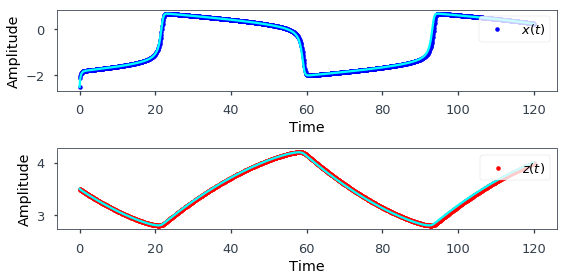

In [21]:
plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.plot(ts,x , 'b.', label='$x(t)$')
plt.plot(ts,y[:,0], 'cyan')

plt.xlabel('Time'); plt.ylabel('Amplitude'); 
plt.legend(loc='upper right')
plt.tight_layout();
plt.subplot(212)
plt.plot(ts, z, 'r.', label='$z(t)$')
plt.plot(ts,y[:,1], 'cyan')
plt.xlabel('Time'); ylabel('Amplitude'); 
plt.legend(loc='upper right')
plt.tight_layout();
plt.show()

plt.show()

In [22]:
x.shape, ts.shape

((1201,), (1201,))

In [23]:
# v=np.zeros(nt)
# v= np.array(x)


# v_th=-1.5
# ind = np.where(v < v_th)
# v[ind] = v_th


# ind1 = np.where(np.diff(v) > 0)

# spike_times1 = np.array(ts)[ind1]
# spike_times_stim1 = spike_times1

# if spike_times_stim1.shape[0] > 0:
#         spike_times_stim1 = spike_times_stim1[np.append(1, np.diff(spike_times_stim1)) > 0.5]
        
        
# ind2 = np.where((v[:-1]<-1) & (np.diff(v) < 0))

# spike_times2 = np.array(ts)[ind2]
# spike_times_stim2 = spike_times2

# if spike_times_stim2.shape[0] > 0:
#         spike_times_stim2 = spike_times_stim2[np.append(1, np.diff(spike_times_stim2)) > 0.5]        

In [169]:
v=np.zeros(nt)
v= np.array(x)


v_th=0
ind = np.where(v < v_th)
v[ind] = v_th


ind = np.where(np.diff(v) < 0)
v[ind] = v_th

spike_times = np.array(ts)[ind]
spike_times_stim = spike_times

if spike_times_stim.shape[0] > 0:
        spike_times_stim = spike_times_stim[np.append(1, np.diff(spike_times_stim)) > 0.75]
        
        
     

In [170]:
spike_times_stim

array([23. , 94.9])

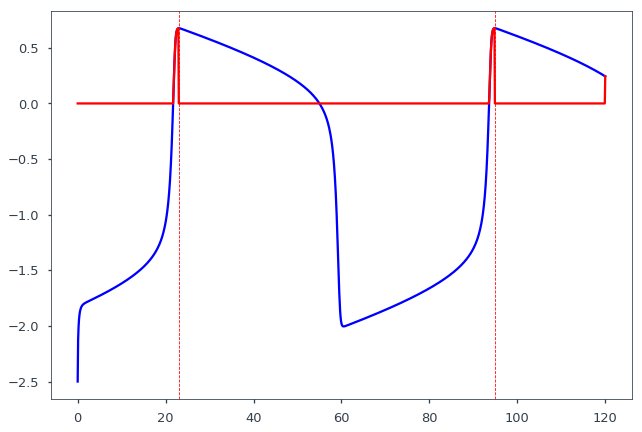

In [171]:
plt.plot(ts,x, 'b');
plt.plot(ts,v, 'r');
for i in np.r_[0:len(spike_times_stim)]:
     plt.axvline(x=spike_times_stim[i], linewidth=.8, color = 'r', linestyle='--')

### Simulator

In [172]:
def Epileptor_ODEmodel(params, constants, dt, ts, seed=None):
   
    eta, x_init, z_init  = params[0], params[1], params[2]
    eta.astype(float)
    x_init.astype(float)
    z_init.astype(float)

    # fixed parameters
    tau0, I1, sigma=constants[0], constants[1], constants[2]
    dt = float(dt)

    if seed is not None:
        rng = np.random.RandomState(seed=seed)
    else:
        rng = np.random.RandomState()

   
    y_init=np.array([x_init, z_init])
    y = odeint(dy_dt, y_init, ts,  args=(eta,))
        
    return y[:,0].reshape(-1)
     

In [174]:
def calculate_summary_statistics(x, dt, ts):
    """Calculate summary statistics

    Parameters
    ----------
    x : output of the simulator

    Returns
    -------
    np.array, summary statistics
    """



    n_mom = 4
    n_summary=7
    n_summary = np.minimum(n_summary, n_mom + 3)

    # initialise array of spike counts
    v=np.zeros(nt)
    v= np.array(x)



    v_th=0
    ind = np.where(v < v_th)
    v[ind] = v_th


    ind = np.where(np.diff(v) < 0)
    v[ind] = v_th

    spike_times = np.array(ts)[ind]
    spike_times_stim = spike_times

    if spike_times_stim.shape[0] > 0:
            spike_times_stim = spike_times_stim[np.append(1, np.diff(spike_times_stim)) > 0.75]
        
        
        
#     ind = np.where(v < 0)
#     v[ind] = 0
#     ind = np.where(np.diff(v) < 0)
#     v[ind] = 0

#     ind = np.where(np.diff(v) < 0)

#     spike_times = np.array(ts)[ind]
#     spike_times_stim = spike_times


#     if spike_times_stim.shape[0] > 0:
#         spike_times_stim = spike_times_stim[np.append(1, np.diff(spike_times_stim)) > 0.5]

        
    std_pw = np.power(np.std(x), np.linspace(3, n_mom, n_mom - 2) )

    std_pw = np.concatenate((np.ones(1), std_pw))


    #momments
    spstats.moment(x, np.linspace(2, n_mom, n_mom - 1))/std_pw

    moments = spstats.moment(v, np.linspace(2, n_mom, n_mom - 1))/ std_pw

    sum_stats_vec = np.concatenate((np.array([spike_times_stim.shape[0]]),
                                    np.array([np.mean(x)]), np.array([np.std(x)]), 
                                    moments,))

    sum_stats_vec = sum_stats_vec[0:n_summary]


    return sum_stats_vec


In [175]:
def Epileptor_ODEsimulator(params):

    params = np.asarray(params)
    
    # input, time step
    constants = np.array([10.0, 3.1, 1e-1])
    T = 120.0
    dt=0.1
    ts = np.arange(0, T + dt, dt)

    states = Epileptor_ODEmodel(params, constants, dt, ts, seed=0)

    return states.reshape(-1)  

In [176]:
def Epileptor_ODEsimulator_wrapper(params):

    params = np.asarray(params)
    
    # input, time step
    constants = np.array([10.0, 3.1, 1e-1])
    T = 120.0
    dt=0.1
    ts = np.arange(0, T + dt, dt)

    states = Epileptor_ODEmodel(params, constants, dt, ts, seed=0)

    summstats = torch.as_tensor(calculate_summary_statistics(states, dt, ts))

    return summstats 

### some simulations

In [177]:
T = 120.0
dt=0.1
t = np.arange(0, T + dt, dt)
sigma=1e-1

In [178]:
# three sets of params (eta, x0, z0)
params = np.array([[-3.5, -2.5, 3.5],[-2.1, -2.5, 3.5],[-1.5, -2.5, 3.5]])
params.shape

(3, 3)

In [179]:
len(params[:,0]), ts.shape

(3, (1201,))

In [180]:
num_p = len(params[:,0])
sim_p = np.zeros((num_p, ts.shape[0]))
sim_stat_p = np.zeros((num_p, 6))

num_p,sim_p.shape

(3, (3, 1201))

In [181]:
sim_stat_p.shape

(3, 6)

In [182]:
for i in range(num_p):
    sim_p[i,:] = Epileptor_ODEsimulator(params=params[i,:])
    sim_stat_p[i,:] = Epileptor_ODEsimulator_wrapper(params=params[i,:])

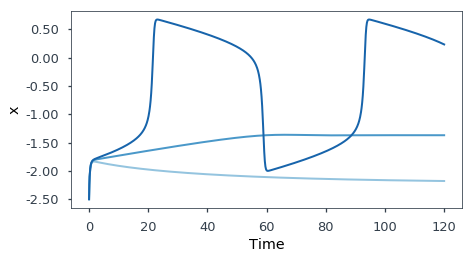

In [183]:
# colors for traces
col_min = 2
num_colors = num_p+col_min
cm1 = mpl.cm.Blues
col1 = [cm1(1.*i/num_colors) for i in range(col_min,num_colors)]


fig = plt.figure(figsize=(7,5))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax = plt.subplot(gs[0])
for i in range(num_p):
    plt.plot(ts,sim_p[i,:],color=col1[i],lw=2)

plt.xlabel('Time'); plt.ylabel('x'); 
#plt.legend(loc='upper right')
#plt.tight_layout();
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_xticks([0, max(t)/2, max(t)])
ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))
plt.show()

In [184]:
sim_stat_p

array([[ 0.        , -2.07955578,  0.09275875,  0.        ,  0.        ,
         0.        ],
       [ 0.        , -1.47169847,  0.1455376 ,  0.        ,  0.        ,
         0.        ],
       [ 2.        , -0.53907189,  1.03789937,  0.00700164,  0.00365607,
         0.00215592]])

## 3. Prior over model parameters

In [185]:
prior_min = [-4., -5., 0.]
prior_max = [-1, 0., 5.]
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

### Inference

In [186]:
start_time = time.time()

posterior = infer(Epileptor_ODEsimulator_wrapper, prior, method='SNPE', num_simulations=1000, num_workers=1)

print ("-"*60)
print("--- %s seconds ---" % (time.time() - start_time))

A Jupyter Widget


Neural network successfully converged after 118 epochs.
------------------------------------------------------------
--- 45.68008780479431 seconds ---


In [187]:
#simulator, prior = prepare_for_sbi(Epileptor_ODEsimulator_wrapper, prior)
#inference = SNPE(simulator, prior)


In [188]:
# num_rounds = 2
# y_obs_summary_statistics=calculate_summary_statistics(y_obs, dt, ts)
# x_o = y_obs_summary_statistics


# posteriors = []
# proposal = None

# for _ in range(num_rounds):
#     posterior = inference(num_simulations=500, proposal=proposal)
#     posteriors.append(posterior)
#     proposal = posterior.set_default_x(x_o)

### Data

In [189]:
# true parameters and respective labels
true_params = np.array([-1.5, -2.5, 3.5])
labels_params = [r'$eta$', r'$x_init$', r'$z_init$']

In [190]:
ts.shape[0]

1201

In [204]:
y_obs=Epileptor_ODEsimulator(params=true_params)
y_obs_summary_statistics=calculate_summary_statistics(y_obs, dt, ts)

In [205]:
y_obs_summary_statistics

array([ 2.        , -0.53907189,  1.03789937,  0.00700164,  0.00365607,
        0.00215592])

In [206]:
y_obs.shape, nt

((1201,), 1201)

In [207]:
y_obs_summary_statistics

array([ 2.        , -0.53907189,  1.03789937,  0.00700164,  0.00365607,
        0.00215592])

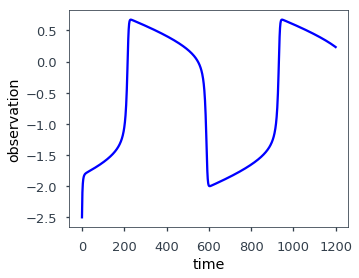

In [208]:
plt.figure(figsize=(5,4))
plt.plot(y_obs[0:nt], 'b')
#plt.plot(y_obs[nt:2*nt], 'r')
plt.xlabel('time')
plt.ylabel('observation')
plt.show()

### Posterior

In [209]:
num_samples=1000

In [210]:
posterior_sample = posterior.sample((num_samples,), y_obs_summary_statistics).numpy()

A Jupyter Widget

In [211]:
posterior_sample.shape

(1000, 3)

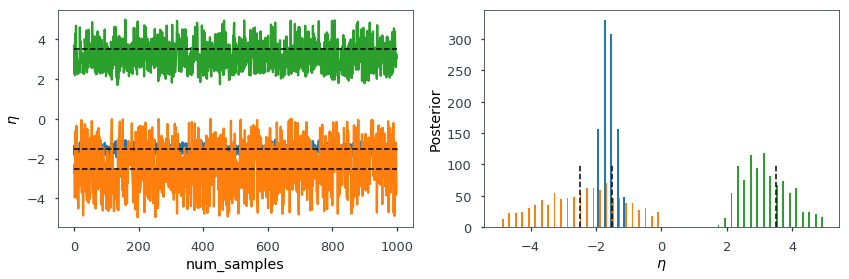

In [212]:
plt.figure(figsize=(14,4))
plt.subplot(121)
plt.plot(posterior_sample)
plt.hlines(y=true_params, xmin=0., xmax=num_samples, linewidth=1.5, color = 'k', linestyle='--', zorder=5)
plt.xlabel('num_samples')
plt.ylabel(r'$\eta$')
plt.subplot(122)
plt.hist(posterior_sample, bins=50)
plt.vlines(x=true_params, ymin=0., ymax=100, linewidth=1.5, color = 'k', linestyle='--', zorder=5)
plt.xlabel(r'$\eta$')
plt.ylabel('Posterior')
plt.show()

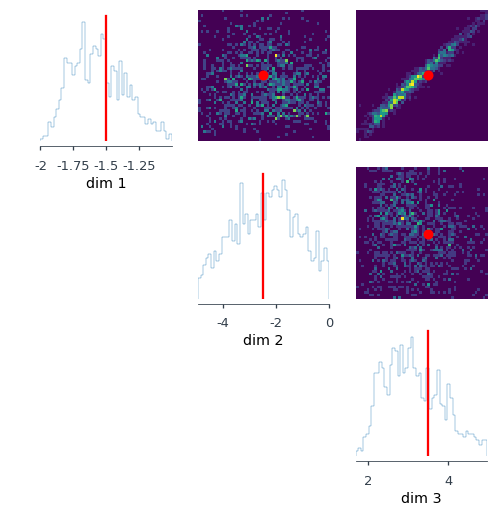

In [213]:
fig, axes = utils.pairplot(posterior_sample,
                           fig_size=(8,8),
                           points=true_params,
                           points_offdiag={'markersize': 20},
                           points_colors='r');

In [214]:
y_fit = Epileptor_ODEsimulator(np.percentile(posterior_sample, [50], axis=0).reshape(-1))
y_ppc_lo = Epileptor_ODEsimulator(np.percentile(posterior_sample, [5], axis=0).reshape(-1))
y_ppc_hi = Epileptor_ODEsimulator(np.percentile(posterior_sample, [95], axis=0).reshape(-1))

In [215]:
y_fit.shape

(1201,)

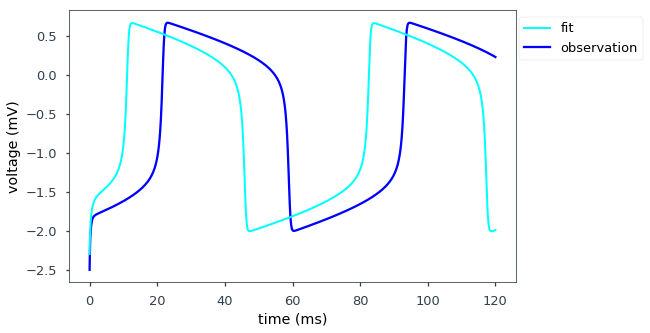

In [216]:
fig = plt.figure(figsize=(8,5))

# plot observation
#plt.plot(ts, y_obs, lw=2, color='b' , label='observation')
plt.plot(ts, y_obs[0:nt], 'b',label='observation')
#plt.plot(ts,y_obs[nt:2*nt], 'r',label='observation')

# simulate and plot samples
plt.plot(ts, y_fit[0:nt], lw=2, color='cyan', label='fit')
#plt.plot(ts, y_fit[nt:2*nt], lw=2, color='cyan', label='fit')


#plt.fill_between(t, y_ppc_lo, y_ppc_hi, color='green', alpha=.6) 
plt.xlabel('time (ms)')
plt.ylabel('voltage (mV)')

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.3, 1), 
          loc='upper right')

plt.show()
# ax.set_xticks([0, 60, 120])
# ax.set_yticks([-80, -20, 40]);